Esta primera celda carga todas las herramientas y librerías que necesitaremos para el proyecto. Esto incluye PyTorch (para la red neuronal), Torchvision (para las imágenes), NumPy (para cálculos), Matplotlib/Seaborn (para gráficos) y Scikit-learn (para las métricas de evaluación).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
)
import os
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import datetime

Aquí definimos todas las constantes y variables clave.

In [2]:
CARPETA_DATOS_AGRUPADOS = './dataset_agrupad_o'
DIRECTORIO_DATOS = CARPETA_DATOS_AGRUPADOS
DIRECTORIO_KAGGLE = "/kaggle/input"

print(f"Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de {DIRECTORIO_KAGGLE}...")

DIRECTORIO_ENTRADA_BIOMAS = None
try:
    for ruta_actual, carpetas, archivos in os.walk(DIRECTORIO_KAGGLE, topdown=True):
        if os.path.basename(ruta_actual) == 'preprocessed_data':
            if any(carpeta.startswith('biome_') for carpeta in carpetas):
                DIRECTORIO_ENTRADA_BIOMAS = ruta_actual
                print(f"Directorio de biomas válido encontrado en: {DIRECTORIO_ENTRADA_BIOMAS}")
                print(f"Subdirectorios de biomas detectados (muestra): {carpetas[:5]}")
                break
    if DIRECTORIO_ENTRADA_BIOMAS is None:
        print("--- ERROR FATAL (DETECCIÓN) ---")
        print("No se pudo encontrar un directorio 'preprocessed_data' válido que contenga subcarpetas 'biome_X'.")
        DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"
except Exception as e:
    print(f"Error fatal al buscar directorios: {e}")
    DIRECTORIO_ENTRADA_BIOMAS = "/kaggle/input/DIRECTORIO_NO_ENCONTRADO"

#Aqui estan definidas estas constantes en funcion de como se presentan las imagenes del dataset 
ALTO_IMAGEN = 180
ANCHO_IMAGEN = 320
TAMANO_LOTE = 32
PROPORCION_VALIDACION = 1 / 3
SEMILLA_ALEATORIA = 123
UMBRAL_MINORIA = 1000

# Este es el mapa de las agrupaciones definidas en el anteproyecto
MAPA_AGRUPACION_BIOMAS = {
    "Taiga": ["biome_5", "biome_19", "biome_32", "biome_33", "biome_133"],
    "Taiga Nevada": ["biome_30", "biome_31", "biome_158"],
    "Savana": ["biome_35", "biome_36"],
    "Jungla": ["biome_21", "biome_22"],
    "Bosque de Roble Oscuro": ["biome_29", "biome_157"],
    "Desierto": ["biome_2", "biome_17", "biome_130"],
    "Badlands": ["biome_37", "biome_38", "biome_39"],
    "Bosque de Abeto": ["biome_27", "biome_28", "biome_156"],
    "Pantano": ["biome_6"],
    "Bosque de Roble": ["biome_4", "biome_132"],
    "Planicies": ["biome_1", "biome_129"],
    "Bosque Mixto": ["biome_18", "biome_34"],
    "Tundra Nevada": ["biome_12"],
    "Montañas": ["biome_3", "biome_131", "biome_162"],
    "Montaña Nevada": ["biome_13"],
    "Playa": ["biome_16", "biome_26"],
    "Ríos": ["biome_7", "biome_11"]
}

BIOMAS_IGNORADOS = ["biome_10", "biome_45"]

Buscando el directorio 'preprocessed_data' con subcarpetas 'biome_' dentro de /kaggle/input...
Directorio de biomas válido encontrado en: /kaggle/input/minecraft-biomes/preprocessed_data
Subdirectorios de biomas detectados (muestra): ['biome_7', 'biome_12', 'biome_37', 'biome_162', 'biome_158']


Esta celda define la función preparar_y_agrupar_biomas

In [3]:
def preparar_y_agrupar_biomas():
    print(f"Directorio base de entrada detectado: {DIRECTORIO_ENTRADA_BIOMAS}")
    if not DIRECTORIO_ENTRADA_BIOMAS or not os.path.exists(DIRECTORIO_ENTRADA_BIOMAS) or not os.listdir(DIRECTORIO_ENTRADA_BIOMAS):
        print(f"--- ERROR FATAL ---\nEl directorio '{DIRECTORIO_ENTRADA_BIOMAS}' no existe o está vacío.")
        return False

    os.makedirs(CARPETA_DATOS_AGRUPADOS, exist_ok=True)
    print(f"El dataset agrupado se guardará en: {CARPETA_DATOS_AGRUPADOS}")

    try:
        nombres_biomas_originales = next(os.walk(DIRECTORIO_ENTRADA_BIOMAS))[1]
    except (StopIteration, FileNotFoundError) as e:
        print(f"Error: No se encontró una estructura de directorios válida en {DIRECTORIO_ENTRADA_BIOMAS}. {e}")
        return False

    mapa_inverso_biomas = {}
    for nueva_categoria, lista_biomas_antiguos in MAPA_AGRUPACION_BIOMAS.items():
        for bioma_antiguo_id in lista_biomas_antiguos:
            mapa_inverso_biomas[bioma_antiguo_id] = nueva_categoria

    print("Creando directorios de salida para las categorías agrupadas...")
    todas_las_categorias = list(MAPA_AGRUPACION_BIOMAS.keys())
    for nueva_categoria in todas_las_categorias:
        os.makedirs(os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria), exist_ok=True)

    biomas_originales_mapeados = set()
    nombre_carpeta_raiz = os.path.basename(DIRECTORIO_ENTRADA_BIOMAS)

    print(f"Recorriendo {DIRECTORIO_ENTRADA_BIOMAS} en busca de imágenes...")
    for ruta_actual, _, archivos in tqdm(os.walk(DIRECTORIO_ENTRADA_BIOMAS), desc="Procesando biomas"):
        bioma_actual_id = os.path.basename(ruta_actual)

        if bioma_actual_id == nombre_carpeta_raiz or bioma_actual_id in BIOMAS_IGNORADOS:
            continue

        if bioma_actual_id in mapa_inverso_biomas:
            biomas_originales_mapeados.add(bioma_actual_id)
            nueva_categoria = mapa_inverso_biomas[bioma_actual_id]
            directorio_nueva_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, nueva_categoria)

            for nombre_imagen in archivos:
                if not nombre_imagen.lower().endswith(('.jpg')):
                    continue

                ruta_origen = os.path.join(ruta_actual, nombre_imagen)
                nombre_destino = f"{bioma_actual_id}_{nombre_imagen}"
                ruta_destino = os.path.join(directorio_nueva_categoria, nombre_destino)

                if os.path.exists(ruta_destino):
                    continue

                try:
                    os.symlink(ruta_origen, ruta_destino)
                except (OSError, NotImplementedError, AttributeError):
                    import shutil
                    shutil.copy2(ruta_origen, ruta_destino)

    print("\n--- Proceso de agrupación completado ---")
    print("\n--- Verificación de Conteo (Desde carpetas de destino) ---")
    conteo_final_categorias = {}
    total_imagenes_agrupadas = 0

    for categoria in todas_las_categorias:
        ruta_categoria = os.path.join(CARPETA_DATOS_AGRUPADOS, categoria)
        try:
            archivos_en_categoria = os.listdir(ruta_categoria)
            conteo = len([f for f in archivos_en_categoria if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        except FileNotFoundError:
            conteo = 0
        conteo_final_categorias[categoria] = conteo
    
    total_imagenes_agrupadas = sum(conteo_final_categorias.values())
    print(f"Total de imágenes encontradas en las carpetas de destino: {total_imagenes_agrupadas}")

    if total_imagenes_agrupadas == 0:
        print("0 imagenes procesadas. ¡Algo salió mal!")
    else:
        print("\nCantidad total de imagenes encontradas:")
        for categoria, conteo in conteo_final_categorias.items():
            print(f"- {categoria}: {conteo} imágenes")

    todos_biomas_originales_en_mapa = biomas_originales_mapeados | set(BIOMAS_IGNORADOS)
    biomas_sin_mapa = [b for b in nombres_biomas_originales if b not in todos_biomas_originales_en_mapa]

    if biomas_sin_mapa:
        print(f"\n¡Atención! Los siguientes directorios no fueron mapeados ni excluidos:")
        for b in biomas_sin_mapa: print(f"  - {b}")
    else:
        print("\n¡Perfecto! Todos los directorios fueron trabajados correctamente.")
    
    return True

Esta celda define cargar_y_preparar_datos

In [4]:
def cargar_y_preparar_datos(directorio_datos):
    if not os.path.exists(directorio_datos) or not os.listdir(directorio_datos):
        print(f"Error: El directorio '{directorio_datos}' está vacío o no existe.")
        return None, None, None, None, 0

    transformaciones_entrenamiento = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomResizedCrop((ALTO_IMAGEN, ANCHO_IMAGEN), scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformaciones_validacion = transforms.Compose([
        transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    print("  -> Escaneando directorio de datos (ImageFolder)...")
    try:
        dataset_completo = datasets.ImageFolder(directorio_datos)
    except Exception as e:
        print(f"Error al cargar datos con ImageFolder desde '{directorio_datos}': {e}")
        return None, None, None, None, 0

    print(f"  -> Escaneo completo. {len(dataset_completo)} imágenes encontradas.")
    nombres_clases = dataset_completo.classes
    numero_de_clases = len(nombres_clases)
    print(f"Clases detectadas ({numero_de_clases}): {nombres_clases}")

    indices = list(range(len(dataset_completo)))
    corte = int(np.floor(PROPORCION_VALIDACION * len(dataset_completo)))

    np.random.seed(SEMILLA_ALEATORIA)
    np.random.shuffle(indices)

    indices_entrenamiento, indices_validacion = indices[corte:], indices[:corte]

    class DatasetPersonalizado(Dataset):
        def __init__(self, subset, transformacion):
            self.subset = subset
            self.transformacion = transformacion
        def __getitem__(self, index):
            imagen, etiqueta = self.subset[index]
            imagen = self.transformacion(imagen)
            return imagen, etiqueta
        def __len__(self):
            return len(self.subset)

    datos_entrenamiento = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_entrenamiento),
        transformacion=transformaciones_entrenamiento
    )
    datos_validacion = DatasetPersonalizado(
        torch.utils.data.Subset(dataset_completo, indices_validacion),
        transformacion=transformaciones_validacion
    )

    print("  -> Calculando pesos para el muestreador (sampler)...")
    etiquetas_entrenamiento = []
    for i in tqdm(indices_entrenamiento, desc="   - Recopilando etiquetas (targets)"):
        etiquetas_entrenamiento.append(dataset_completo.targets[i])

    conteo_por_clase = np.bincount(etiquetas_entrenamiento, minlength=numero_de_clases)

    for i, nombre_clase in enumerate(nombres_clases):
        conteo = conteo_por_clase[i]
        if conteo < UMBRAL_MINORIA and conteo > 0:
            print(f"  -> (Sobremuestreo): {nombre_clase} (índice {i}) con {conteo} imágenes.")
        else:
            print(f"  -> (Normal): {nombre_clase} (índice {i}) con {conteo} imágenes.")

    conteo_por_clase[conteo_por_clase == 0] = 1
    pesos_por_clase = 1. / conteo_por_clase

    lista_pesos_muestras = []
    for t in tqdm(etiquetas_entrenamiento, desc="   - Calculando pesos (weights)"):
        lista_pesos_muestras.append(pesos_por_clase[t])
    pesos_muestras_tensor = torch.from_numpy(np.array(lista_pesos_muestras)).double()

    print("  -> Creando DataLoader de Validación...")
    cargador_validacion = DataLoader(datos_validacion,
                                   batch_size=TAMANO_LOTE,
                                   shuffle=False,
                                   num_workers=2,
                                   pin_memory=True)

    print(f"\nDatasets listos. Entreno: {len(datos_entrenamiento)}, Prueba: {len(datos_validacion)}")
    return datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases

Esta celda define la arquitectura de nuestra Red Neuronal Convolucional (CNN) usando una clase de PyTorch.

In [5]:
class ClasificadorBiomasCNN(nn.Module):
    def __init__(self, numero_de_clases, tipo_arquitectura="estandar"):
        super(ClasificadorBiomasCNN, self).__init__()
        self.tipo_arquitectura = tipo_arquitectura

        capas_convolucionales = []
        if tipo_arquitectura == "estandar":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(64, 128, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(128, 256, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 256 * 11 * 20

        elif tipo_arquitectura == "simple":
            capas_convolucionales.append(nn.Conv2d(3, 32, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            capas_convolucionales.append(nn.Conv2d(32, 64, kernel_size=3, padding=1))
            capas_convolucionales.append(nn.ReLU())
            capas_convolucionales.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.tamano_vector_aplanado = 64 * 45 * 80

        else:
            raise ValueError("Tipo de arquitectura no reconocido. Use 'estandar' o 'simple'.")

        self.extractor_caracteristicas = nn.Sequential(*capas_convolucionales)

        capas_clasificacion = []
        if tipo_arquitectura == "estandar":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 512))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(512, 256))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(256, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(128, 64))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.4))
            capas_clasificacion.append(nn.Linear(64, 32))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.3))
            capas_clasificacion.append(nn.Linear(32, numero_de_clases))

        elif tipo_arquitectura == "simple":
            capas_clasificacion.append(nn.Linear(self.tamano_vector_aplanado, 128))
            capas_clasificacion.append(nn.ReLU())
            capas_clasificacion.append(nn.Dropout(0.5))
            capas_clasificacion.append(nn.Linear(128, numero_de_clases))
        self.clasificador_final = nn.Sequential(*capas_clasificacion)

    def forward(self, imagen):
        caracteristicas = self.extractor_caracteristicas(imagen)
        vector_plano = torch.flatten(caracteristicas, 1)
        puntuaciones = self.clasificador_final(vector_plano)
        return puntuaciones

Esta celda contiene las funciones que gestionan el ciclo de vida del modelo.

In [6]:
def entrenar_modelo(red_neuronal, cargador_entrenamiento, numero_epocas, tasa_aprendizaje, dispositivo):
    funcion_de_perdida = nn.CrossEntropyLoss()
    optimizador = optim.Adam(red_neuronal.parameters(), lr=tasa_aprendizaje)
    historial_perdida = []
    red_neuronal.to(dispositivo)

    for epoca in range(numero_epocas):
        perdida_acumulada = 0.0   
        red_neuronal.train()
        barra_progreso = tqdm(cargador_entrenamiento, desc=f"Época {epoca+1}/{numero_epocas}", unit="batch")

        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            optimizador.zero_grad()
            salidas = red_neuronal(imagenes)
            perdida = funcion_de_perdida(salidas, etiquetas)
            perdida.backward()
            optimizador.step()
            perdida_acumulada += perdida.item()
            barra_progreso.set_postfix(loss=perdida.item())
        perdida_promedio_epoca = perdida_acumulada / len(cargador_entrenamiento)
        historial_perdida.append(perdida_promedio_epoca)
        print(f"Época {epoca+1}/{numero_epocas} completada. Loss Promedio: {perdida_promedio_epoca:.4f}")
    print("Entrenamiento finalizado.")
    return historial_perdida

def graficar_historial_perdida(historial_perdida):
    plt.figure()
    plt.plot(historial_perdida, label='Pérdida (Loss) de Entrenamiento')
    plt.title("Historial de Pérdida (Loss) por Época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluar_modelo(red_neuronal, cargador_pruebas, dispositivo, nombres_clases):
    red_neuronal.to(dispositivo)
    red_neuronal.eval()
    todas_predicciones = []
    todas_etiquetas_reales = []
    print("Evaluando modelo contra el conjunto de prueba...")
    barra_progreso = tqdm(cargador_pruebas, desc="Evaluando", unit="batch")
    with torch.no_grad():
        for imagenes, etiquetas in barra_progreso:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = red_neuronal(imagenes)
            _, prediccion = torch.max(salidas.data, 1)         
            todas_predicciones.extend(prediccion.cpu().numpy())
            todas_etiquetas_reales.extend(etiquetas.cpu().numpy())
    accuracy = accuracy_score(todas_etiquetas_reales, todas_predicciones)
    precision = precision_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)
    recall = recall_score(todas_etiquetas_reales, todas_predicciones, average='macro', zero_division=0)

    print("\n" + "="*60)
    print("          RESULTADOS DE LA EVALUACIÓN (BIOMAS)")
    print("="*60)
    print(f"Accuracy (Exactitud): {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision (Precisión - Macro): {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall (Sensibilidad - Macro): {recall:.4f} ({recall*100:.2f}%)")
    print("="*60)
    print("\n--- Reporte de Clasificación (Precisión, Recall, F1) ---")
    print(classification_report(todas_etiquetas_reales, todas_predicciones, target_names=nombres_clases, zero_division=0))
    print("Generando Matriz de Confusión...")
    matriz_confusion = confusion_matrix(todas_etiquetas_reales, todas_predicciones)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues',
                xticklabels=nombres_clases, yticklabels=nombres_clases, annot_kws={"size": 10})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel("Bioma Predicho", fontsize=12)
    ax.set_ylabel("Bioma Real", fontsize=12)
    ax.set_title("Matriz de Confusión - Biomas", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()
    print("Gráfico de Matriz de Confusión generado.")

Esta celda define funciones de ayuda para gestionar el modelo y probarlo.

In [7]:
def guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo):
    estado_modelo = {
        'state_dict': red_neuronal.to('cpu').state_dict(),
        'arch_params': parametros_arquitectura
    }
    ruta_guardado = os.path.basename(nombre_archivo)
    if not ruta_guardado:
        ruta_guardado = "mi_modelo.pth"     
    torch.save(estado_modelo, ruta_guardado)
    print(f"Modelo guardado en {os.path.abspath(ruta_guardado)}")

def cargar_red_neuronal(nombre_archivo, dispositivo):
    if not os.path.exists(nombre_archivo):
        print(f"Error: El archivo '{nombre_archivo}' no existe.")
        return None, None       
    try:
        estado_cargado = torch.load(nombre_archivo, map_location=dispositivo)
    except Exception as e:
        print(f"Error al leer el archivo. ¿Es un archivo .pth válido? ({e})")
        return None, None
    if 'arch_params' not in estado_cargado or 'state_dict' not in estado_cargado:
        print("Error: El archivo .pth no contiene 'arch_params' o 'state_dict'.")
        return None, None
    parametros_arquitectura = estado_cargado['arch_params']
    if 'num_classes' not in parametros_arquitectura and 'numero_de_clases' in parametros_arquitectura:
        parametros_arquitectura['num_classes'] = parametros_arquitectura.pop('numero_de_clases')
    if 'architecture_type' not in parametros_arquitectura and 'tipo_arquitectura' in parametros_arquitectura:
        parametros_arquitectura['architecture_type'] = parametros_arquitectura.pop('tipo_arquitectura')
    params_creacion = {
        'numero_de_clases': parametros_arquitectura['num_classes'],
        'tipo_arquitectura': parametros_arquitectura.get('architecture_type', 'estandar') # default
    }
    red_neuronal = ClasificadorBiomasCNN(**params_creacion) 
    red_neuronal.load_state_dict(estado_cargado['state_dict'])
    red_neuronal.to(dispositivo)
    print(f"Modelo cargado desde {nombre_archivo} al dispositivo {dispositivo}")
    print("\n--- Configuración de la Red Cargada ---")
    print(f"Tipo: {params_creacion['tipo_arquitectura']}")
    print(f"Salida (Clases): {params_creacion['numero_de_clases']}")
    print(red_neuronal)
    print("--------------------------------------")
    return red_neuronal, parametros_arquitectura

def buscar_imagenes_para_predecir(directorio_busqueda, directorio_a_excluir):
    rutas_imagenes_encontradas = []
    print(f"Buscando imágenes de prueba en: {directorio_busqueda}")
    excluir_dataset_dir = ""
    if directorio_a_excluir and os.path.exists(directorio_a_excluir):
        excluir_dataset_dir = os.path.abspath(directorio_a_excluir)
        print(f"Excluyendo directorio de dataset: {excluir_dataset_dir}")      
    excluir_output_dir = os.path.abspath(CARPETA_DATOS_AGRUPADOS)
    print(f"Excluyendo directorio de salida: {excluir_output_dir}")
    for ruta_actual, _, archivos in os.walk(directorio_busqueda, topdown=True):
        ruta_absoluta = os.path.abspath(ruta_actual) 
        if excluir_dataset_dir and ruta_absoluta.startswith(excluir_dataset_dir):
            continue
        if ruta_absoluta.startswith(excluir_output_dir):
            continue
        for nombre_archivo in archivos:
            if nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                ruta_completa = os.path.join(ruta_actual, nombre_archivo)
                rutas_imagenes_encontradas.append(ruta_completa)
                
    return rutas_imagenes_encontradas

def predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo):
    print("\n--- Predecir Imagen Individual (Desde Lista) ---")
    imagenes_encontradas = buscar_imagenes_para_predecir(DIRECTORIO_KAGGLE, DIRECTORIO_ENTRADA_BIOMAS)
    
    if not imagenes_encontradas:
        print(f"No se encontraron imágenes de prueba (jpg, png) en '{DIRECTORIO_KAGGLE}'")
        print(f"(Asegúrese de que NO estén dentro de '{DIRECTORIO_ENTRADA_BIOMAS}')")
        print("Por favor, añada un dataset que contenga imágenes de prueba (ej. 'test-images').")
        return

    print("Imágenes de prueba encontradas:")
    for i, ruta_img in enumerate(imagenes_encontradas):
        ruta_mostrada = ruta_img.replace(DIRECTORIO_KAGGLE, '.../input')
        print(f"  {i + 1}: {ruta_mostrada}")

    ruta_elegida = None
    while ruta_elegida is None:
        try:
            opcion_str = input(f"Seleccione el número de la imagen (1-{len(imagenes_encontradas)}): ")
            opcion_int = int(opcion_str) - 1
            if 0 <= opcion_int < len(imagenes_encontradas):
                ruta_elegida = imagenes_encontradas[opcion_int]
            else:
                print("Número fuera de rango. Intente de nuevo.")
        except ValueError:
            print("Entrada no válida. Por favor, ingrese un número.")

    print(f"Cargando imagen seleccionada: {ruta_elegida}")
    try:
        transformaciones_prediccion = transforms.Compose([
            transforms.Resize((ALTO_IMAGEN, ANCHO_IMAGEN)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        imagen = Image.open(ruta_elegida).convert("RGB")
        imagen_tensor = transformaciones_prediccion(imagen)
        imagen_lote = imagen_tensor.unsqueeze(0)
        red_neuronal.to(dispositivo)
        red_neuronal.eval()

        with torch.no_grad():
            salidas = red_neuronal(imagen_lote.to(dispositivo))
            probabilidades = torch.nn.functional.softmax(salidas, dim=1)
            puntuaciones = probabilidades[0]
            confianza, indice_predicho = torch.max(puntuaciones, 0)

        clase_predicha = nombres_clases[indice_predicho.item()]

        print("\n--- Resultado ---")
        print(f"Archivo: {os.path.basename(ruta_elegida)}")
        print(f"La red cree que es: {clase_predicha}")
        print(f"Confianza: {confianza.item() * 100:.2f}%")

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")

Esta celda define la interfaz de usuario que nos permite interactuar con el modelo cuando corre en draft

In [8]:
def menu_interactivo_modelo(red_neuronal, parametros_arquitectura, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo):
    historial_perdida = []
    
    while True:
        print("\n--- Menú de Red - Clasificador de Biomas ---")
        print(f"Modelo en memoria: {parametros_arquitectura.get('architecture_type', 'N/A')}")
        print("1. Entrenar la red")
        print("2. Probar (Evaluar) la red")
        print("3. Predecir imagen individual")
        print("4. Guardar la red")
        print("5. Volver al menú principal")
        opcion = input("Seleccione una opción: ")

        if opcion == '1':
            try:
                epocas = int(input("Ingrese el número de épocas (ej. 10): ") or 10)
                lr = float(input("Ingrese la tasa de aprendizaje (ej. 0.001): ") or 0.001)
                porcentaje_str = input("Porcentaje del dataset de entrenamiento a usar (1-100) [Default: 100]: ") or "100"
                porcentaje = float(porcentaje_str) / 100.0
                
                if not (0.01 <= porcentaje <= 1.0):
                    print("Porcentaje inválido. Usando 100%.")
                    porcentaje = 1.0
                    
                total_muestras_entrenamiento = len(pesos_muestras_tensor)
                
                if porcentaje < 1.0:
                    muestras_a_usar = int(total_muestras_entrenamiento * porcentaje)
                    print(f"Usando {porcentaje*100:.0f}% del dataset. {muestras_a_usar} muestras por época.")
                else:
                    muestras_a_usar = total_muestras_entrenamiento
                    print(f"Usando 100% del dataset. {muestras_a_usar} muestras por época.")

                muestreador_entrenamiento = torch.utils.data.WeightedRandomSampler(
                    weights=pesos_muestras_tensor,
                    num_samples=muestras_a_usar,
                    replacement=True
                )
                
                cargador_entrenamiento_actual = DataLoader(datos_entrenamiento,
                                                          batch_size=TAMANO_LOTE,
                                                          sampler=muestreador_entrenamiento,
                                                          num_workers=2,
                                                          pin_memory=True)

                print(f"Entrenando por {epocas} épocas con LR={lr} en {dispositivo}...")
                nueva_perdida = entrenar_modelo(red_neuronal, cargador_entrenamiento_actual, epocas, lr, dispositivo)
                historial_perdida.extend(nueva_perdida)
                graficar_historial_perdida(historial_perdida)

            except ValueError:
                print("Error: Entrada no válida.")
        
        elif opcion == '2':
            print(f"Probando modelo contra el conjunto de prueba en {dispositivo}...")
            evaluar_modelo(red_neuronal, cargador_validacion, dispositivo, nombres_clases)
        
        elif opcion == '3':
            predecir_imagen_individual(red_neuronal, nombres_clases, dispositivo)
        
        elif opcion == '4':
            nombre_archivo = input("Ingrese el nombre para guardar el modelo (ej: mi_modelo.pth): ")
            if not nombre_archivo.endswith(".pth"):
                nombre_archivo += ".pth"
            if nombre_archivo:
                guardar_red_neuronal(red_neuronal, parametros_arquitectura, nombre_archivo)
            else:
                print("Guardado cancelado (nombre vacío).")
        
        elif opcion == '5':
            print("Volviendo al menú principal...")
            break
        
        else:
            print("Opción no válida. Intente de nuevo.")

def menu_principal():
    red_neuronal_activa = None
    params_arquitectura_activos = None
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    while True:
        print("\n" + "="*50)
        print("  Panel de Control - Clasificador de Biomas (PyTorch)")
        print(f" (Usando dispositivo: {dispositivo})")
        print("="*50)
        print("1. Preparar datos y Crear nueva red (CNN)")
        print("2. Cargar una red desde archivo (.pth)")
        print("3. Salir")
        opcion_principal = input("Seleccione una opción: ")

        if opcion_principal == '1':
            try:
                print("\n--- FASE 1: Agrupando y verificando el dataset ---")
                if not preparar_y_agrupar_biomas():
                    print("Error crítico en la agrupación del dataset. Abortando.")
                    continue

                print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
                
                if datos_entrenamiento is None:
                    print("No se pudieron cargar los datos. Volviendo al menú.")
                    continue
                print("\n--- FASE 3: Creación de Modelo (CNN) ---")
                opcion_arquitectura = input("¿Qué arquitectura desea? (1: Estándar, 2: Simple) [Default: 1]: ") or "1"
                tipo_arquitectura = "simple" if opcion_arquitectura == "2" else "estandar"
                params_arquitectura_activos = {
                    'num_classes': numero_de_clases,
                    'architecture_type': tipo_arquitectura
                }
                
                params_creacion_modelo = {
                    'numero_de_clases': params_arquitectura_activos['num_classes'],
                    'tipo_arquitectura': params_arquitectura_activos['architecture_type']
                }

                red_neuronal_activa = ClasificadorBiomasCNN(**params_creacion_modelo).to(dispositivo)
                print("\n--- Nueva Red CNN Creada ---")
                print(red_neuronal_activa)
                print("------------------------------")  
                menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except ValueError:
                print("Error: Entrada numérica no válida.")
            except Exception as e:
                print(f"Ocurrió un error creando la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '2':
            print("\n--- Cargar Modelo ---")
            print("Buscando archivos .pth en el directorio actual y subdirectorios...")
            archivos_pth_encontrados = []
            for ruta_actual, _, archivos in os.walk('.'):
                for f in archivos:
                    if f.endswith(".pth"):
                        archivos_pth_encontrados.append(os.path.join(ruta_actual, f))
            
            if not archivos_pth_encontrados:
                print("No se encontraron archivos .pth.")
                print("Asegúrate de haber guardado un modelo previamente.")
                continue

            print("Archivos .pth encontrados:")
            for i, ruta_archivo in enumerate(archivos_pth_encontrados):
                print(f"  {i + 1}: {ruta_archivo}")
            nombre_archivo_cargado = None
            while nombre_archivo_cargado is None:
                try:
                    opcion_str = input(f"Seleccione el número del modelo a cargar (1-{len(archivos_pth_encontrados)}): ")
                    opcion_int = int(opcion_str) - 1
                    if 0 <= opcion_int < len(archivos_pth_encontrados):
                        nombre_archivo_cargado = archivos_pth_encontrados[opcion_int]
                    else:
                        print("Número fuera de rango.")
                except ValueError:
                    print("Entrada no válida.")
            
            print(f"Cargando modelo: {nombre_archivo_cargado}")
            try:
                red_neuronal_activa, params_arquitectura_activos = cargar_red_neuronal(nombre_archivo_cargado, dispositivo)
                
                if red_neuronal_activa and params_arquitectura_activos:
                    print("\n--- FASE 1: Verificando datos (necesarios para la red cargada) ---")
                    if not os.path.exists(DIRECTORIO_DATOS) or not os.listdir(DIRECTORIO_DATOS):
                        print("El directorio de datos agrupados no existe. Ejecutando agrupación...")
                        if not preparar_y_agrupar_biomas():
                            print("Error crítico en la agrupación del dataset. Abortando.")
                            continue
                    else:
                        print("Directorio de datos agrupados encontrado.")
                    print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
                    datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)           
                    if datos_entrenamiento is None:
                        print("No se pudieron cargar los datos para la red. Volviendo al menú.")
                        continue        
                    if numero_de_clases != params_arquitectura_activos['num_classes']:
                        print(f"¡ADVERTENCIA! El modelo fue entrenado con {params_arquitectura_activos['num_classes']} clases,")
                        print(f"pero los datos en '{DIRECTORIO_DATOS}' tienen {numero_de_clases} clases.")
                        print("Esto causará un error. Asegúrate de que los datos agrupados coincidan con el modelo.")
                        continue
                        
                    menu_interactivo_modelo(red_neuronal_activa, params_arquitectura_activos, datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, dispositivo)

            except FileNotFoundError:
                print(f"Error: El archivo '{nombre_archivo_cargado}' no fue encontrado.")
            except Exception as e:
                print(f"Ocurrió un error al cargar o probar la red: {e}")
                import traceback
                traceback.print_exc()

        elif opcion_principal == '3':
            print("Saliendo del programa.")
            break
        
        else:
            print("Opción no válida. Por favor, intente de nuevo.")

Punto de ejecucion del codigo donde se termina de definir

--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---
Iniciando flujo automático (sin inputs).

 (Usando dispositivo: cuda)

--- FASE 1: Agrupando y verificando el dataset ---
Directorio base de entrada detectado: /kaggle/input/minecraft-biomes/preprocessed_data
El dataset agrupado se guardará en: ./dataset_agrupad_o
Creando directorios de salida para las categorías agrupadas...
Recorriendo /kaggle/input/minecraft-biomes/preprocessed_data en busca de imágenes...


Procesando biomas: 42it [01:03,  1.50s/it]



--- Proceso de agrupación completado ---

--- Verificación de Conteo (Desde carpetas de destino) ---
Total de imágenes encontradas en las carpetas de destino: 22049

Cantidad total de imagenes encontradas:
- Taiga: 2346 imágenes
- Taiga Nevada: 420 imágenes
- Savana: 1164 imágenes
- Jungla: 444 imágenes
- Bosque de Roble Oscuro: 870 imágenes
- Desierto: 2088 imágenes
- Badlands: 210 imágenes
- Bosque de Abeto: 1122 imágenes
- Pantano: 665 imágenes
- Bosque de Roble: 2850 imágenes
- Planicies: 3186 imágenes
- Bosque Mixto: 1320 imágenes
- Tundra Nevada: 1254 imágenes
- Montañas: 2652 imágenes
- Montaña Nevada: 474 imágenes
- Playa: 540 imágenes
- Ríos: 444 imágenes

¡Perfecto! Todos los directorios fueron trabajados correctamente.

--- FASE 2: Cargando y preparando datasets (PyTorch) ---
  -> Escaneando directorio de datos (ImageFolder)...
  -> Escaneo completo. 22049 imágenes encontradas.
Clases detectadas (17): ['Badlands', 'Bosque Mixto', 'Bosque de Abeto', 'Bosque de Roble', 'Bosqu

   - Recopilando etiquetas (targets): 100%|██████████| 14700/14700 [00:00<00:00, 3318778.60it/s]


  -> (Sobremuestreo): Badlands (índice 0) con 146 imágenes.
  -> (Sobremuestreo): Bosque Mixto (índice 1) con 861 imágenes.
  -> (Sobremuestreo): Bosque de Abeto (índice 2) con 767 imágenes.
  -> (Normal): Bosque de Roble (índice 3) con 1920 imágenes.
  -> (Sobremuestreo): Bosque de Roble Oscuro (índice 4) con 568 imágenes.
  -> (Normal): Desierto (índice 5) con 1406 imágenes.
  -> (Sobremuestreo): Jungla (índice 6) con 305 imágenes.
  -> (Sobremuestreo): Montaña Nevada (índice 7) con 301 imágenes.
  -> (Normal): Montañas (índice 8) con 1783 imágenes.
  -> (Sobremuestreo): Pantano (índice 9) con 450 imágenes.
  -> (Normal): Planicies (índice 10) con 2122 imágenes.
  -> (Sobremuestreo): Playa (índice 11) con 356 imágenes.
  -> (Sobremuestreo): Ríos (índice 12) con 306 imágenes.
  -> (Sobremuestreo): Savana (índice 13) con 774 imágenes.
  -> (Normal): Taiga (índice 14) con 1534 imágenes.
  -> (Sobremuestreo): Taiga Nevada (índice 15) con 273 imágenes.
  -> (Sobremuestreo): Tundra Nevada 

   - Calculando pesos (weights): 100%|██████████| 14700/14700 [00:00<00:00, 2999867.11it/s]

  -> Creando DataLoader de Validación...

Datasets listos. Entreno: 14700, Prueba: 7349

--- FASE 3: Creación de Modelo (CNN) ---
Arquitectura seleccionada: estandar



--- Nueva Red CNN Creada ---

--- FASE 4: Iniciando Entrenamiento ---
Épocas: 350, LR: 0.001, Dataset: 100%


Época 1/350: 100%|██████████| 460/460 [01:21<00:00,  5.67batch/s, loss=2.35]


Época 1/350 completada. Loss Promedio: 2.5347


Época 2/350: 100%|██████████| 460/460 [01:06<00:00,  6.87batch/s, loss=1.4]


Época 2/350 completada. Loss Promedio: 2.1178


Época 3/350: 100%|██████████| 460/460 [01:01<00:00,  7.43batch/s, loss=1.81]


Época 3/350 completada. Loss Promedio: 1.8295


Época 4/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.985]


Época 4/350 completada. Loss Promedio: 1.6093


Época 5/350: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=1.78]


Época 5/350 completada. Loss Promedio: 1.5126


Época 6/350: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=1.27]


Época 6/350 completada. Loss Promedio: 1.4569


Época 7/350: 100%|██████████| 460/460 [00:59<00:00,  7.75batch/s, loss=1.05]


Época 7/350 completada. Loss Promedio: 1.3586


Época 8/350: 100%|██████████| 460/460 [00:58<00:00,  7.86batch/s, loss=0.963]


Época 8/350 completada. Loss Promedio: 1.3070


Época 9/350: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.492]


Época 9/350 completada. Loss Promedio: 1.2763


Época 10/350: 100%|██████████| 460/460 [01:00<00:00,  7.61batch/s, loss=1.74]


Época 10/350 completada. Loss Promedio: 1.2529


Época 11/350: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=1.22]


Época 11/350 completada. Loss Promedio: 1.1897


Época 12/350: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=2.12]


Época 12/350 completada. Loss Promedio: 1.1866


Época 13/350: 100%|██████████| 460/460 [00:59<00:00,  7.77batch/s, loss=0.967]


Época 13/350 completada. Loss Promedio: 1.1426


Época 14/350: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=1.22]


Época 14/350 completada. Loss Promedio: 1.0771


Época 15/350: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=1.1]


Época 15/350 completada. Loss Promedio: 1.0943


Época 16/350: 100%|██████████| 460/460 [01:00<00:00,  7.57batch/s, loss=1.18]


Época 16/350 completada. Loss Promedio: 1.0009


Época 17/350: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=1.02]


Época 17/350 completada. Loss Promedio: 0.9974


Época 18/350: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=2.09]


Época 18/350 completada. Loss Promedio: 1.0020


Época 19/350: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=1.16]


Época 19/350 completada. Loss Promedio: 0.9529


Época 20/350: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.376]


Época 20/350 completada. Loss Promedio: 0.9784


Época 21/350: 100%|██████████| 460/460 [01:00<00:00,  7.65batch/s, loss=2.07]


Época 21/350 completada. Loss Promedio: 0.9559


Época 22/350: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=1.59]


Época 22/350 completada. Loss Promedio: 0.8991


Época 23/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.862]


Época 23/350 completada. Loss Promedio: 0.9564


Época 24/350: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=1.19]


Época 24/350 completada. Loss Promedio: 0.9237


Época 25/350: 100%|██████████| 460/460 [00:55<00:00,  8.22batch/s, loss=0.599]


Época 25/350 completada. Loss Promedio: 0.8650


Época 26/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=1.55]


Época 26/350 completada. Loss Promedio: 0.8483


Época 27/350: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.497]


Época 27/350 completada. Loss Promedio: 0.8221


Época 28/350: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.276]


Época 28/350 completada. Loss Promedio: 0.9586


Época 29/350: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.31]


Época 29/350 completada. Loss Promedio: 0.8521


Época 30/350: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.26]


Época 30/350 completada. Loss Promedio: 0.8569


Época 31/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.975]


Época 31/350 completada. Loss Promedio: 0.8339


Época 32/350: 100%|██████████| 460/460 [00:59<00:00,  7.67batch/s, loss=0.367]


Época 32/350 completada. Loss Promedio: 0.8359


Época 33/350: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.252]


Época 33/350 completada. Loss Promedio: 0.7831


Época 34/350: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.681]


Época 34/350 completada. Loss Promedio: 0.8107


Época 35/350: 100%|██████████| 460/460 [00:54<00:00,  8.40batch/s, loss=0.43]


Época 35/350 completada. Loss Promedio: 0.8397


Época 36/350: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.72]


Época 36/350 completada. Loss Promedio: 0.7448


Época 37/350: 100%|██████████| 460/460 [00:54<00:00,  8.41batch/s, loss=0.75]


Época 37/350 completada. Loss Promedio: 0.7792


Época 38/350: 100%|██████████| 460/460 [00:54<00:00,  8.50batch/s, loss=0.565]


Época 38/350 completada. Loss Promedio: 0.7400


Época 39/350: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.23]


Época 39/350 completada. Loss Promedio: 0.7736


Época 40/350: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=1.01]


Época 40/350 completada. Loss Promedio: 0.7933


Época 41/350: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=1.1]


Época 41/350 completada. Loss Promedio: 0.7226


Época 42/350: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.782]


Época 42/350 completada. Loss Promedio: 0.7307


Época 43/350: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.757]


Época 43/350 completada. Loss Promedio: 0.7000


Época 44/350: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.517]


Época 44/350 completada. Loss Promedio: 0.6817


Época 45/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.632]


Época 45/350 completada. Loss Promedio: 0.7469


Época 46/350: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=1.03]


Época 46/350 completada. Loss Promedio: 0.7266


Época 47/350: 100%|██████████| 460/460 [00:57<00:00,  8.07batch/s, loss=0.757]


Época 47/350 completada. Loss Promedio: 0.7178


Época 48/350: 100%|██████████| 460/460 [00:54<00:00,  8.42batch/s, loss=0.937]


Época 48/350 completada. Loss Promedio: 0.7292


Época 49/350: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=1.27]


Época 49/350 completada. Loss Promedio: 0.7108


Época 50/350: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=1.03]


Época 50/350 completada. Loss Promedio: 0.6967


Época 51/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.671]


Época 51/350 completada. Loss Promedio: 0.6770


Época 52/350: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.387]


Época 52/350 completada. Loss Promedio: 0.7142


Época 53/350: 100%|██████████| 460/460 [00:53<00:00,  8.64batch/s, loss=0.603]


Época 53/350 completada. Loss Promedio: 0.6696


Época 54/350: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.361]


Época 54/350 completada. Loss Promedio: 0.6672


Época 55/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.345]


Época 55/350 completada. Loss Promedio: 0.6399


Época 56/350: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.382]


Época 56/350 completada. Loss Promedio: 0.6639


Época 57/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.521]


Época 57/350 completada. Loss Promedio: 0.7092


Época 58/350: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=1.72]


Época 58/350 completada. Loss Promedio: 0.6434


Época 59/350: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.906]


Época 59/350 completada. Loss Promedio: 0.6592


Época 60/350: 100%|██████████| 460/460 [00:53<00:00,  8.58batch/s, loss=0.719]


Época 60/350 completada. Loss Promedio: 0.6818


Época 61/350: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.194]


Época 61/350 completada. Loss Promedio: 0.6257


Época 62/350: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.473]


Época 62/350 completada. Loss Promedio: 0.6577


Época 63/350: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.258]


Época 63/350 completada. Loss Promedio: 0.6413


Época 64/350: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=1.36]


Época 64/350 completada. Loss Promedio: 0.6199


Época 65/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.452]


Época 65/350 completada. Loss Promedio: 0.6359


Época 66/350: 100%|██████████| 460/460 [00:53<00:00,  8.57batch/s, loss=0.157]


Época 66/350 completada. Loss Promedio: 0.6073


Época 67/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=3.17]


Época 67/350 completada. Loss Promedio: 0.5961


Época 68/350: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.506]


Época 68/350 completada. Loss Promedio: 0.6994


Época 69/350: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.415]


Época 69/350 completada. Loss Promedio: 0.6215


Época 70/350: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.539]


Época 70/350 completada. Loss Promedio: 0.5866


Época 71/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.632]


Época 71/350 completada. Loss Promedio: 0.6460


Época 72/350: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.75]


Época 72/350 completada. Loss Promedio: 0.6065


Época 73/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.442]


Época 73/350 completada. Loss Promedio: 0.5974


Época 74/350: 100%|██████████| 460/460 [00:53<00:00,  8.59batch/s, loss=0.172]


Época 74/350 completada. Loss Promedio: 0.5757


Época 75/350: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.548]


Época 75/350 completada. Loss Promedio: 0.5960


Época 76/350: 100%|██████████| 460/460 [00:53<00:00,  8.54batch/s, loss=0.496]


Época 76/350 completada. Loss Promedio: 0.6453


Época 77/350: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.772]


Época 77/350 completada. Loss Promedio: 0.5994


Época 78/350: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.449]


Época 78/350 completada. Loss Promedio: 0.6266


Época 79/350: 100%|██████████| 460/460 [00:54<00:00,  8.52batch/s, loss=0.451]


Época 79/350 completada. Loss Promedio: 0.5719


Época 80/350: 100%|██████████| 460/460 [00:52<00:00,  8.72batch/s, loss=0.835]


Época 80/350 completada. Loss Promedio: 0.6491


Época 81/350: 100%|██████████| 460/460 [00:53<00:00,  8.56batch/s, loss=0.494]


Época 81/350 completada. Loss Promedio: 0.6046


Época 82/350: 100%|██████████| 460/460 [00:53<00:00,  8.61batch/s, loss=0.64]


Época 82/350 completada. Loss Promedio: 0.6072


Época 83/350: 100%|██████████| 460/460 [00:58<00:00,  7.93batch/s, loss=0.856]


Época 83/350 completada. Loss Promedio: 0.5729


Época 84/350: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=0.621]


Época 84/350 completada. Loss Promedio: 0.6329


Época 85/350: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=0.281]


Época 85/350 completada. Loss Promedio: 0.5720


Época 86/350: 100%|██████████| 460/460 [00:54<00:00,  8.46batch/s, loss=0.644]


Época 86/350 completada. Loss Promedio: 0.5687


Época 87/350: 100%|██████████| 460/460 [00:52<00:00,  8.73batch/s, loss=0.875]


Época 87/350 completada. Loss Promedio: 0.5363


Época 88/350: 100%|██████████| 460/460 [00:53<00:00,  8.60batch/s, loss=0.302]


Época 88/350 completada. Loss Promedio: 0.7084


Época 89/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.11]


Época 89/350 completada. Loss Promedio: 0.5983


Época 90/350: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.221]


Época 90/350 completada. Loss Promedio: 0.5990


Época 91/350: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.256]


Época 91/350 completada. Loss Promedio: 0.6015


Época 92/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.845]


Época 92/350 completada. Loss Promedio: 0.5686


Época 93/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.452]


Época 93/350 completada. Loss Promedio: 0.5758


Época 94/350: 100%|██████████| 460/460 [00:53<00:00,  8.67batch/s, loss=0.424]


Época 94/350 completada. Loss Promedio: 0.5698


Época 95/350: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.65]


Época 95/350 completada. Loss Promedio: 0.6056


Época 96/350: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.24]


Época 96/350 completada. Loss Promedio: 0.6021


Época 97/350: 100%|██████████| 460/460 [00:55<00:00,  8.31batch/s, loss=0.512]


Época 97/350 completada. Loss Promedio: 0.5466


Época 98/350: 100%|██████████| 460/460 [00:58<00:00,  7.85batch/s, loss=0.354]


Época 98/350 completada. Loss Promedio: 0.5924


Época 99/350: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.657]


Época 99/350 completada. Loss Promedio: 0.5887


Época 100/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.185]


Época 100/350 completada. Loss Promedio: 0.5779


Época 101/350: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=2.43]


Época 101/350 completada. Loss Promedio: 0.5701


Época 102/350: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.486]


Época 102/350 completada. Loss Promedio: 0.5406


Época 103/350: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.923]


Época 103/350 completada. Loss Promedio: 0.5473


Época 104/350: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=1.41]


Época 104/350 completada. Loss Promedio: 0.8085


Época 105/350: 100%|██████████| 460/460 [00:58<00:00,  7.93batch/s, loss=0.467]


Época 105/350 completada. Loss Promedio: 0.7782


Época 106/350: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.278]


Época 106/350 completada. Loss Promedio: 0.5477


Época 107/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.34]


Época 107/350 completada. Loss Promedio: 0.5672


Época 108/350: 100%|██████████| 460/460 [01:00<00:00,  7.63batch/s, loss=0.476]


Época 108/350 completada. Loss Promedio: 0.6864


Época 109/350: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.289]


Época 109/350 completada. Loss Promedio: 0.6634


Época 110/350: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.892]


Época 110/350 completada. Loss Promedio: 0.5685


Época 111/350: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=1.07]


Época 111/350 completada. Loss Promedio: 0.5220


Época 112/350: 100%|██████████| 460/460 [00:58<00:00,  7.86batch/s, loss=0.39]


Época 112/350 completada. Loss Promedio: 0.6758


Época 113/350: 100%|██████████| 460/460 [00:58<00:00,  7.91batch/s, loss=0.93]


Época 113/350 completada. Loss Promedio: 0.5620


Época 114/350: 100%|██████████| 460/460 [01:00<00:00,  7.62batch/s, loss=0.725]


Época 114/350 completada. Loss Promedio: 0.5714


Época 115/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.258]


Época 115/350 completada. Loss Promedio: 0.5971


Época 116/350: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.345]


Época 116/350 completada. Loss Promedio: 0.5511


Época 117/350: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.312]


Época 117/350 completada. Loss Promedio: 0.5195


Época 118/350: 100%|██████████| 460/460 [00:59<00:00,  7.73batch/s, loss=0.376]


Época 118/350 completada. Loss Promedio: 0.6557


Época 119/350: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.127]


Época 119/350 completada. Loss Promedio: 0.5267


Época 120/350: 100%|██████████| 460/460 [00:57<00:00,  7.93batch/s, loss=0.277]


Época 120/350 completada. Loss Promedio: 0.5949


Época 121/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.54]


Época 121/350 completada. Loss Promedio: 0.5662


Época 122/350: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.25]


Época 122/350 completada. Loss Promedio: 0.5305


Época 123/350: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=0.715]


Época 123/350 completada. Loss Promedio: 0.5192


Época 124/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.53]


Época 124/350 completada. Loss Promedio: 0.5557


Época 125/350: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.829]


Época 125/350 completada. Loss Promedio: 0.5715


Época 126/350: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=0.376]


Época 126/350 completada. Loss Promedio: 0.5246


Época 127/350: 100%|██████████| 460/460 [00:58<00:00,  7.81batch/s, loss=0.688]


Época 127/350 completada. Loss Promedio: 0.5300


Época 128/350: 100%|██████████| 460/460 [00:54<00:00,  8.44batch/s, loss=0.481]


Época 128/350 completada. Loss Promedio: 0.5840


Época 129/350: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.749]


Época 129/350 completada. Loss Promedio: 0.5854


Época 130/350: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=1.23]


Época 130/350 completada. Loss Promedio: 0.5903


Época 131/350: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=1.48]


Época 131/350 completada. Loss Promedio: 0.5494


Época 132/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.863]


Época 132/350 completada. Loss Promedio: 0.5033


Época 133/350: 100%|██████████| 460/460 [01:00<00:00,  7.66batch/s, loss=0.437]


Época 133/350 completada. Loss Promedio: 0.5396


Época 134/350: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.79]


Época 134/350 completada. Loss Promedio: 0.5497


Época 135/350: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.612]


Época 135/350 completada. Loss Promedio: 0.5671


Época 136/350: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.537]


Época 136/350 completada. Loss Promedio: 0.5453


Época 137/350: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.521]


Época 137/350 completada. Loss Promedio: 0.5485


Época 138/350: 100%|██████████| 460/460 [00:56<00:00,  8.14batch/s, loss=0.243]


Época 138/350 completada. Loss Promedio: 0.5825


Época 139/350: 100%|██████████| 460/460 [00:55<00:00,  8.26batch/s, loss=0.42]


Época 139/350 completada. Loss Promedio: 0.5298


Época 140/350: 100%|██████████| 460/460 [00:55<00:00,  8.25batch/s, loss=1.14]


Época 140/350 completada. Loss Promedio: 0.5275


Época 141/350: 100%|██████████| 460/460 [01:00<00:00,  7.59batch/s, loss=0.198]


Época 141/350 completada. Loss Promedio: 0.5311


Época 142/350: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=0.35]


Época 142/350 completada. Loss Promedio: 0.5221


Época 143/350: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.528]


Época 143/350 completada. Loss Promedio: 0.5301


Época 144/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.543]


Época 144/350 completada. Loss Promedio: 0.5438


Época 145/350: 100%|██████████| 460/460 [01:02<00:00,  7.39batch/s, loss=0.0378]


Época 145/350 completada. Loss Promedio: 0.5651


Época 146/350: 100%|██████████| 460/460 [01:00<00:00,  7.58batch/s, loss=0.186]


Época 146/350 completada. Loss Promedio: 0.5074


Época 147/350: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.203]


Época 147/350 completada. Loss Promedio: 0.4909


Época 148/350: 100%|██████████| 460/460 [00:56<00:00,  8.21batch/s, loss=0.166]


Época 148/350 completada. Loss Promedio: 0.5150


Época 149/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.52]


Época 149/350 completada. Loss Promedio: 0.5237


Época 150/350: 100%|██████████| 460/460 [00:59<00:00,  7.74batch/s, loss=0.359]


Época 150/350 completada. Loss Promedio: 0.5665


Época 151/350: 100%|██████████| 460/460 [01:00<00:00,  7.59batch/s, loss=0.398]


Época 151/350 completada. Loss Promedio: 0.5832


Época 152/350: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.178]


Época 152/350 completada. Loss Promedio: 0.5013


Época 153/350: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.0679]


Época 153/350 completada. Loss Promedio: 0.5112


Época 154/350: 100%|██████████| 460/460 [01:00<00:00,  7.60batch/s, loss=0.108]


Época 154/350 completada. Loss Promedio: 0.5167


Época 155/350: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.587]


Época 155/350 completada. Loss Promedio: 0.5298


Época 156/350: 100%|██████████| 460/460 [01:00<00:00,  7.60batch/s, loss=0.533]


Época 156/350 completada. Loss Promedio: 0.5901


Época 157/350: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.18]


Época 157/350 completada. Loss Promedio: 0.5385


Época 158/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.417]


Época 158/350 completada. Loss Promedio: 0.5302


Época 159/350: 100%|██████████| 460/460 [01:01<00:00,  7.47batch/s, loss=0.238]


Época 159/350 completada. Loss Promedio: 0.5365


Época 160/350: 100%|██████████| 460/460 [00:59<00:00,  7.72batch/s, loss=0.476]


Época 160/350 completada. Loss Promedio: 0.5018


Época 161/350: 100%|██████████| 460/460 [00:59<00:00,  7.76batch/s, loss=0.159]


Época 161/350 completada. Loss Promedio: 0.5268


Época 162/350: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.244]


Época 162/350 completada. Loss Promedio: 0.5559


Época 163/350: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=0.407]


Época 163/350 completada. Loss Promedio: 0.5625


Época 164/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.267]


Época 164/350 completada. Loss Promedio: 0.4780


Época 165/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.694]


Época 165/350 completada. Loss Promedio: 0.5387


Época 166/350: 100%|██████████| 460/460 [01:02<00:00,  7.40batch/s, loss=0.285]


Época 166/350 completada. Loss Promedio: 0.5489


Época 167/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.491]


Época 167/350 completada. Loss Promedio: 0.5188


Época 168/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.465]


Época 168/350 completada. Loss Promedio: 0.5643


Época 169/350: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.184]


Época 169/350 completada. Loss Promedio: 0.5050


Época 170/350: 100%|██████████| 460/460 [00:59<00:00,  7.77batch/s, loss=0.274]


Época 170/350 completada. Loss Promedio: 0.5186


Época 171/350: 100%|██████████| 460/460 [00:58<00:00,  7.83batch/s, loss=0.68]


Época 171/350 completada. Loss Promedio: 0.6881


Época 172/350: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.286]


Época 172/350 completada. Loss Promedio: 0.7087


Época 173/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.632]


Época 173/350 completada. Loss Promedio: 0.5097


Época 174/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.207]


Época 174/350 completada. Loss Promedio: 0.5100


Época 175/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.445]


Época 175/350 completada. Loss Promedio: 0.4834


Época 176/350: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.584]


Época 176/350 completada. Loss Promedio: 0.5378


Época 177/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.782]


Época 177/350 completada. Loss Promedio: 0.4960


Época 178/350: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.585]


Época 178/350 completada. Loss Promedio: 0.5358


Época 179/350: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.548]


Época 179/350 completada. Loss Promedio: 0.5032


Época 180/350: 100%|██████████| 460/460 [00:55<00:00,  8.32batch/s, loss=1.2]


Época 180/350 completada. Loss Promedio: 0.5679


Época 181/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.281]


Época 181/350 completada. Loss Promedio: 0.5001


Época 182/350: 100%|██████████| 460/460 [00:58<00:00,  7.85batch/s, loss=0.156]


Época 182/350 completada. Loss Promedio: 0.4581


Época 183/350: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.696]


Época 183/350 completada. Loss Promedio: 0.4769


Época 184/350: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.161]


Época 184/350 completada. Loss Promedio: 0.5466


Época 185/350: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.961]


Época 185/350 completada. Loss Promedio: 0.5080


Época 186/350: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=1.61]


Época 186/350 completada. Loss Promedio: 0.5294


Época 187/350: 100%|██████████| 460/460 [01:01<00:00,  7.42batch/s, loss=0.75]


Época 187/350 completada. Loss Promedio: 0.5338


Época 188/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.23]


Época 188/350 completada. Loss Promedio: 0.4859


Época 189/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.353]


Época 189/350 completada. Loss Promedio: 0.5177


Época 190/350: 100%|██████████| 460/460 [00:59<00:00,  7.76batch/s, loss=0.359]


Época 190/350 completada. Loss Promedio: 0.5282


Época 191/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.647]


Época 191/350 completada. Loss Promedio: 0.4920


Época 192/350: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=1.32]


Época 192/350 completada. Loss Promedio: 0.4743


Época 193/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.331]


Época 193/350 completada. Loss Promedio: 0.4695


Época 194/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.22]


Época 194/350 completada. Loss Promedio: 0.5236


Época 195/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.154]


Época 195/350 completada. Loss Promedio: 0.7197


Época 196/350: 100%|██████████| 460/460 [00:58<00:00,  7.84batch/s, loss=0.377]


Época 196/350 completada. Loss Promedio: 0.5404


Época 197/350: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.442]


Época 197/350 completada. Loss Promedio: 0.4766


Época 198/350: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.586]


Época 198/350 completada. Loss Promedio: 0.5098


Época 199/350: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.346]


Época 199/350 completada. Loss Promedio: 0.4952


Época 200/350: 100%|██████████| 460/460 [01:02<00:00,  7.41batch/s, loss=0.798]


Época 200/350 completada. Loss Promedio: 0.4697


Época 201/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.958]


Época 201/350 completada. Loss Promedio: 0.5575


Época 202/350: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.754]


Época 202/350 completada. Loss Promedio: 0.5000


Época 203/350: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.154]


Época 203/350 completada. Loss Promedio: 0.5214


Época 204/350: 100%|██████████| 460/460 [00:58<00:00,  7.87batch/s, loss=0.138]


Época 204/350 completada. Loss Promedio: 0.5549


Época 205/350: 100%|██████████| 460/460 [01:00<00:00,  7.63batch/s, loss=0.588]


Época 205/350 completada. Loss Promedio: 0.5200


Época 206/350: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.105]


Época 206/350 completada. Loss Promedio: 0.5053


Época 207/350: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.329]


Época 207/350 completada. Loss Promedio: 0.5192


Época 208/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.251]


Época 208/350 completada. Loss Promedio: 0.4671


Época 209/350: 100%|██████████| 460/460 [00:55<00:00,  8.30batch/s, loss=0.39]


Época 209/350 completada. Loss Promedio: 0.4783


Época 210/350: 100%|██████████| 460/460 [00:58<00:00,  7.83batch/s, loss=0.561]


Época 210/350 completada. Loss Promedio: 0.5205


Época 211/350: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.408]


Época 211/350 completada. Loss Promedio: 0.5123


Época 212/350: 100%|██████████| 460/460 [00:57<00:00,  8.02batch/s, loss=0.731]


Época 212/350 completada. Loss Promedio: 0.5074


Época 213/350: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.66]


Época 213/350 completada. Loss Promedio: 0.5938


Época 214/350: 100%|██████████| 460/460 [01:02<00:00,  7.32batch/s, loss=0.913]


Época 214/350 completada. Loss Promedio: 0.5154


Época 215/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.374]


Época 215/350 completada. Loss Promedio: 0.5419


Época 216/350: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.189]


Época 216/350 completada. Loss Promedio: 0.4991


Época 217/350: 100%|██████████| 460/460 [00:59<00:00,  7.75batch/s, loss=0.585]


Época 217/350 completada. Loss Promedio: 0.4852


Época 218/350: 100%|██████████| 460/460 [00:59<00:00,  7.74batch/s, loss=0.236]


Época 218/350 completada. Loss Promedio: 0.5083


Época 219/350: 100%|██████████| 460/460 [00:58<00:00,  7.80batch/s, loss=2.31]


Época 219/350 completada. Loss Promedio: 0.5462


Época 220/350: 100%|██████████| 460/460 [00:56<00:00,  8.16batch/s, loss=0.295]


Época 220/350 completada. Loss Promedio: 0.4914


Época 221/350: 100%|██████████| 460/460 [00:55<00:00,  8.27batch/s, loss=0.137]


Época 221/350 completada. Loss Promedio: 0.4760


Época 222/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.0992]


Época 222/350 completada. Loss Promedio: 0.5034


Época 223/350: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.703]


Época 223/350 completada. Loss Promedio: 0.5275


Época 224/350: 100%|██████████| 460/460 [01:00<00:00,  7.59batch/s, loss=0.516]


Época 224/350 completada. Loss Promedio: 0.4618


Época 225/350: 100%|██████████| 460/460 [00:56<00:00,  8.12batch/s, loss=0.223]


Época 225/350 completada. Loss Promedio: 0.4725


Época 226/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.339]


Época 226/350 completada. Loss Promedio: 0.5533


Época 227/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.754]


Época 227/350 completada. Loss Promedio: 0.5278


Época 228/350: 100%|██████████| 460/460 [01:03<00:00,  7.23batch/s, loss=0.584]


Época 228/350 completada. Loss Promedio: 0.4798


Época 229/350: 100%|██████████| 460/460 [00:57<00:00,  7.99batch/s, loss=1.54]


Época 229/350 completada. Loss Promedio: 0.4993


Época 230/350: 100%|██████████| 460/460 [00:58<00:00,  7.84batch/s, loss=0.241]


Época 230/350 completada. Loss Promedio: 0.4622


Época 231/350: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=1.04]


Época 231/350 completada. Loss Promedio: 0.4643


Época 232/350: 100%|██████████| 460/460 [00:54<00:00,  8.37batch/s, loss=1.56]


Época 232/350 completada. Loss Promedio: 0.6364


Época 233/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.457]


Época 233/350 completada. Loss Promedio: 0.5782


Época 234/350: 100%|██████████| 460/460 [00:56<00:00,  8.08batch/s, loss=0.744]


Época 234/350 completada. Loss Promedio: 0.5081


Época 235/350: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=1.89]


Época 235/350 completada. Loss Promedio: 0.4672


Época 236/350: 100%|██████████| 460/460 [01:01<00:00,  7.51batch/s, loss=0.383]


Época 236/350 completada. Loss Promedio: 0.4656


Época 237/350: 100%|██████████| 460/460 [01:02<00:00,  7.41batch/s, loss=0.768]


Época 237/350 completada. Loss Promedio: 0.4672


Época 238/350: 100%|██████████| 460/460 [00:59<00:00,  7.68batch/s, loss=0.191]


Época 238/350 completada. Loss Promedio: 0.4476


Época 239/350: 100%|██████████| 460/460 [01:01<00:00,  7.53batch/s, loss=0.329]


Época 239/350 completada. Loss Promedio: 0.4639


Época 240/350: 100%|██████████| 460/460 [00:59<00:00,  7.74batch/s, loss=0.352]


Época 240/350 completada. Loss Promedio: 0.4442


Época 241/350: 100%|██████████| 460/460 [00:59<00:00,  7.72batch/s, loss=0.0446]


Época 241/350 completada. Loss Promedio: 0.5996


Época 242/350: 100%|██████████| 460/460 [01:03<00:00,  7.25batch/s, loss=0.347]


Época 242/350 completada. Loss Promedio: 0.4555


Época 243/350: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.567]


Época 243/350 completada. Loss Promedio: 0.4726


Época 244/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.762]


Época 244/350 completada. Loss Promedio: 0.4711


Época 245/350: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.324]


Época 245/350 completada. Loss Promedio: 0.4448


Época 246/350: 100%|██████████| 460/460 [01:03<00:00,  7.29batch/s, loss=0.435]


Época 246/350 completada. Loss Promedio: 0.5146


Época 247/350: 100%|██████████| 460/460 [00:59<00:00,  7.79batch/s, loss=0.422]


Época 247/350 completada. Loss Promedio: 0.5104


Época 248/350: 100%|██████████| 460/460 [00:57<00:00,  8.00batch/s, loss=0.298]


Época 248/350 completada. Loss Promedio: 0.5020


Época 249/350: 100%|██████████| 460/460 [00:58<00:00,  7.89batch/s, loss=0.164]


Época 249/350 completada. Loss Promedio: 0.4910


Época 250/350: 100%|██████████| 460/460 [00:55<00:00,  8.34batch/s, loss=0.218]


Época 250/350 completada. Loss Promedio: 0.5379


Época 251/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.467]


Época 251/350 completada. Loss Promedio: 0.4889


Época 252/350: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.296]


Época 252/350 completada. Loss Promedio: 0.4944


Época 253/350: 100%|██████████| 460/460 [01:02<00:00,  7.38batch/s, loss=0.123]


Época 253/350 completada. Loss Promedio: 0.4617


Época 254/350: 100%|██████████| 460/460 [01:00<00:00,  7.66batch/s, loss=0.524]


Época 254/350 completada. Loss Promedio: 0.4725


Época 255/350: 100%|██████████| 460/460 [00:57<00:00,  8.06batch/s, loss=0.179]


Época 255/350 completada. Loss Promedio: 0.4690


Época 256/350: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.934]


Época 256/350 completada. Loss Promedio: 0.4906


Época 257/350: 100%|██████████| 460/460 [00:58<00:00,  7.82batch/s, loss=0.209]


Época 257/350 completada. Loss Promedio: 0.4928


Época 258/350: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.0781]


Época 258/350 completada. Loss Promedio: 0.5967


Época 259/350: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.221]


Época 259/350 completada. Loss Promedio: 0.5407


Época 260/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=1.69]


Época 260/350 completada. Loss Promedio: 0.4939


Época 261/350: 100%|██████████| 460/460 [01:01<00:00,  7.42batch/s, loss=0.22]


Época 261/350 completada. Loss Promedio: 0.4877


Época 262/350: 100%|██████████| 460/460 [00:57<00:00,  8.07batch/s, loss=0.317]


Época 262/350 completada. Loss Promedio: 0.5639


Época 263/350: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=0.893]


Época 263/350 completada. Loss Promedio: 0.4929


Época 264/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.851]


Época 264/350 completada. Loss Promedio: 0.4801


Época 265/350: 100%|██████████| 460/460 [00:54<00:00,  8.47batch/s, loss=0.205]


Época 265/350 completada. Loss Promedio: 0.4943


Época 266/350: 100%|██████████| 460/460 [00:57<00:00,  8.01batch/s, loss=0.354]


Época 266/350 completada. Loss Promedio: 0.4482


Época 267/350: 100%|██████████| 460/460 [00:57<00:00,  7.96batch/s, loss=0.276]


Época 267/350 completada. Loss Promedio: 0.5485


Época 268/350: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.222]


Época 268/350 completada. Loss Promedio: 0.4625


Época 269/350: 100%|██████████| 460/460 [01:01<00:00,  7.47batch/s, loss=0.498]


Época 269/350 completada. Loss Promedio: 0.4491


Época 270/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.115]


Época 270/350 completada. Loss Promedio: 0.4683


Época 271/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.15]


Época 271/350 completada. Loss Promedio: 0.5359


Época 272/350: 100%|██████████| 460/460 [00:59<00:00,  7.75batch/s, loss=0.419]


Época 272/350 completada. Loss Promedio: 0.4816


Época 273/350: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=1.15]


Época 273/350 completada. Loss Promedio: 0.5928


Época 274/350: 100%|██████████| 460/460 [00:55<00:00,  8.24batch/s, loss=0.374]


Época 274/350 completada. Loss Promedio: 0.5078


Época 275/350: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.667]


Época 275/350 completada. Loss Promedio: 0.5408


Época 276/350: 100%|██████████| 460/460 [01:01<00:00,  7.43batch/s, loss=1.17]


Época 276/350 completada. Loss Promedio: 0.4725


Época 277/350: 100%|██████████| 460/460 [00:58<00:00,  7.87batch/s, loss=0.446]


Época 277/350 completada. Loss Promedio: 0.5304


Época 278/350: 100%|██████████| 460/460 [01:04<00:00,  7.18batch/s, loss=1.05]


Época 278/350 completada. Loss Promedio: 0.5464


Época 279/350: 100%|██████████| 460/460 [00:56<00:00,  8.19batch/s, loss=0.167]


Época 279/350 completada. Loss Promedio: 0.5991


Época 280/350: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.851]


Época 280/350 completada. Loss Promedio: 0.5375


Época 281/350: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.296]


Época 281/350 completada. Loss Promedio: 0.5043


Época 282/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.605]


Época 282/350 completada. Loss Promedio: 0.5295


Época 283/350: 100%|██████████| 460/460 [00:58<00:00,  7.88batch/s, loss=0.439]


Época 283/350 completada. Loss Promedio: 0.4486


Época 284/350: 100%|██████████| 460/460 [00:58<00:00,  7.90batch/s, loss=0.126]


Época 284/350 completada. Loss Promedio: 0.4657


Época 285/350: 100%|██████████| 460/460 [00:54<00:00,  8.38batch/s, loss=0.341]


Época 285/350 completada. Loss Promedio: 0.4934


Época 286/350: 100%|██████████| 460/460 [01:00<00:00,  7.60batch/s, loss=0.327]


Época 286/350 completada. Loss Promedio: 0.6088


Época 287/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.216]


Época 287/350 completada. Loss Promedio: 0.4526


Época 288/350: 100%|██████████| 460/460 [00:56<00:00,  8.18batch/s, loss=0.0644]


Época 288/350 completada. Loss Promedio: 0.5165


Época 289/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.288]


Época 289/350 completada. Loss Promedio: 0.5312


Época 290/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.299]


Época 290/350 completada. Loss Promedio: 0.6049


Época 291/350: 100%|██████████| 460/460 [01:00<00:00,  7.66batch/s, loss=0.487]


Época 291/350 completada. Loss Promedio: 0.4475


Época 292/350: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.746]


Época 292/350 completada. Loss Promedio: 0.5177


Época 293/350: 100%|██████████| 460/460 [01:01<00:00,  7.48batch/s, loss=0.353]


Época 293/350 completada. Loss Promedio: 0.4557


Época 294/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.627]


Época 294/350 completada. Loss Promedio: 0.9608


Época 295/350: 100%|██████████| 460/460 [00:57<00:00,  8.04batch/s, loss=0.108]


Época 295/350 completada. Loss Promedio: 0.6251


Época 296/350: 100%|██████████| 460/460 [00:56<00:00,  8.09batch/s, loss=0.311]


Época 296/350 completada. Loss Promedio: 0.4863


Época 297/350: 100%|██████████| 460/460 [01:02<00:00,  7.39batch/s, loss=0.97]


Época 297/350 completada. Loss Promedio: 0.5195


Época 298/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.576]


Época 298/350 completada. Loss Promedio: 0.4998


Época 299/350: 100%|██████████| 460/460 [00:54<00:00,  8.39batch/s, loss=0.288]


Época 299/350 completada. Loss Promedio: 0.4856


Época 300/350: 100%|██████████| 460/460 [00:57<00:00,  8.07batch/s, loss=1.51]


Época 300/350 completada. Loss Promedio: 0.4576


Época 301/350: 100%|██████████| 460/460 [00:55<00:00,  8.35batch/s, loss=0.467]


Época 301/350 completada. Loss Promedio: 0.5487


Época 302/350: 100%|██████████| 460/460 [01:00<00:00,  7.66batch/s, loss=0.145]


Época 302/350 completada. Loss Promedio: 0.5593


Época 303/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.173]


Época 303/350 completada. Loss Promedio: 0.4712


Época 304/350: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=1.34]


Época 304/350 completada. Loss Promedio: 0.5010


Época 305/350: 100%|██████████| 460/460 [00:59<00:00,  7.70batch/s, loss=0.391]


Época 305/350 completada. Loss Promedio: 0.5893


Época 306/350: 100%|██████████| 460/460 [00:58<00:00,  7.92batch/s, loss=0.91]


Época 306/350 completada. Loss Promedio: 0.5610


Época 307/350: 100%|██████████| 460/460 [01:00<00:00,  7.63batch/s, loss=0.341]


Época 307/350 completada. Loss Promedio: 0.6302


Época 308/350: 100%|██████████| 460/460 [00:57<00:00,  7.98batch/s, loss=0.0702]


Época 308/350 completada. Loss Promedio: 0.4992


Época 309/350: 100%|██████████| 460/460 [00:55<00:00,  8.29batch/s, loss=0.0437]


Época 309/350 completada. Loss Promedio: 0.5973


Época 310/350: 100%|██████████| 460/460 [00:55<00:00,  8.23batch/s, loss=0.238]


Época 310/350 completada. Loss Promedio: 0.4845


Época 311/350: 100%|██████████| 460/460 [00:56<00:00,  8.11batch/s, loss=0.515]


Época 311/350 completada. Loss Promedio: 0.5444


Época 312/350: 100%|██████████| 460/460 [00:58<00:00,  7.93batch/s, loss=0.686]


Época 312/350 completada. Loss Promedio: 0.4600


Época 313/350: 100%|██████████| 460/460 [00:56<00:00,  8.20batch/s, loss=0.57]


Época 313/350 completada. Loss Promedio: 0.5096


Época 314/350: 100%|██████████| 460/460 [00:59<00:00,  7.78batch/s, loss=0.522]


Época 314/350 completada. Loss Promedio: 0.5595


Época 315/350: 100%|██████████| 460/460 [01:00<00:00,  7.65batch/s, loss=0.41]


Época 315/350 completada. Loss Promedio: 0.4459


Época 316/350: 100%|██████████| 460/460 [00:59<00:00,  7.71batch/s, loss=0.445]


Época 316/350 completada. Loss Promedio: 0.5499


Época 317/350: 100%|██████████| 460/460 [00:57<00:00,  8.03batch/s, loss=0.493]


Época 317/350 completada. Loss Promedio: 0.4557


Época 318/350: 100%|██████████| 460/460 [01:00<00:00,  7.64batch/s, loss=0.375]


Época 318/350 completada. Loss Promedio: 0.5119


Época 319/350: 100%|██████████| 460/460 [00:57<00:00,  7.97batch/s, loss=0.848]


Época 319/350 completada. Loss Promedio: 0.5128


Época 320/350: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.303]


Época 320/350 completada. Loss Promedio: 0.5008


Época 321/350: 100%|██████████| 460/460 [00:53<00:00,  8.53batch/s, loss=0.942]


Época 321/350 completada. Loss Promedio: 0.4917


Época 322/350: 100%|██████████| 460/460 [00:57<00:00,  7.95batch/s, loss=0.645]


Época 322/350 completada. Loss Promedio: 0.5080


Época 323/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.875]


Época 323/350 completada. Loss Promedio: 0.4517


Época 324/350: 100%|██████████| 460/460 [01:01<00:00,  7.52batch/s, loss=1.04]


Época 324/350 completada. Loss Promedio: 0.5328


Época 325/350: 100%|██████████| 460/460 [01:02<00:00,  7.39batch/s, loss=2.42]


Época 325/350 completada. Loss Promedio: 0.4502


Época 326/350: 100%|██████████| 460/460 [00:58<00:00,  7.85batch/s, loss=0.226]


Época 326/350 completada. Loss Promedio: 0.4421


Época 327/350: 100%|██████████| 460/460 [00:54<00:00,  8.43batch/s, loss=0.256]


Época 327/350 completada. Loss Promedio: 0.5005


Época 328/350: 100%|██████████| 460/460 [01:00<00:00,  7.55batch/s, loss=0.928]


Época 328/350 completada. Loss Promedio: 0.5981


Época 329/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.511]


Época 329/350 completada. Loss Promedio: 0.6962


Época 330/350: 100%|██████████| 460/460 [00:57<00:00,  7.94batch/s, loss=7.38]


Época 330/350 completada. Loss Promedio: 0.7048


Época 331/350: 100%|██████████| 460/460 [00:53<00:00,  8.63batch/s, loss=0.0899]


Época 331/350 completada. Loss Promedio: 0.5945


Época 332/350: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.407]


Época 332/350 completada. Loss Promedio: 0.5559


Época 333/350: 100%|██████████| 460/460 [00:59<00:00,  7.77batch/s, loss=0.308]


Época 333/350 completada. Loss Promedio: 0.4907


Época 334/350: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.0833]


Época 334/350 completada. Loss Promedio: 0.4316


Época 335/350: 100%|██████████| 460/460 [00:57<00:00,  8.05batch/s, loss=0.274]


Época 335/350 completada. Loss Promedio: 0.5222


Época 336/350: 100%|██████████| 460/460 [00:54<00:00,  8.48batch/s, loss=0.712]


Época 336/350 completada. Loss Promedio: 0.5286


Época 337/350: 100%|██████████| 460/460 [01:03<00:00,  7.29batch/s, loss=0.631]


Época 337/350 completada. Loss Promedio: 0.5903


Época 338/350: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.415]


Época 338/350 completada. Loss Promedio: 0.4572


Época 339/350: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.582]


Época 339/350 completada. Loss Promedio: 0.5592


Época 340/350: 100%|██████████| 460/460 [00:56<00:00,  8.15batch/s, loss=0.169]


Época 340/350 completada. Loss Promedio: 0.4886


Época 341/350: 100%|██████████| 460/460 [00:54<00:00,  8.45batch/s, loss=0.798]


Época 341/350 completada. Loss Promedio: 0.4952


Época 342/350: 100%|██████████| 460/460 [00:56<00:00,  8.13batch/s, loss=0.38]


Época 342/350 completada. Loss Promedio: 0.5477


Época 343/350: 100%|██████████| 460/460 [00:53<00:00,  8.55batch/s, loss=0.706]


Época 343/350 completada. Loss Promedio: 0.5795


Época 344/350: 100%|██████████| 460/460 [00:55<00:00,  8.28batch/s, loss=0.748]


Época 344/350 completada. Loss Promedio: 0.5237


Época 345/350: 100%|██████████| 460/460 [00:55<00:00,  8.36batch/s, loss=0.381]


Época 345/350 completada. Loss Promedio: 0.4528


Época 346/350: 100%|██████████| 460/460 [00:58<00:00,  7.86batch/s, loss=0.699]


Época 346/350 completada. Loss Promedio: 0.4636


Época 347/350: 100%|██████████| 460/460 [01:01<00:00,  7.50batch/s, loss=0.33]


Época 347/350 completada. Loss Promedio: 0.4549


Época 348/350: 100%|██████████| 460/460 [00:53<00:00,  8.52batch/s, loss=0.375]


Época 348/350 completada. Loss Promedio: 0.6764


Época 349/350: 100%|██████████| 460/460 [00:56<00:00,  8.10batch/s, loss=0.395]


Época 349/350 completada. Loss Promedio: 0.5142


Época 350/350: 100%|██████████| 460/460 [00:56<00:00,  8.17batch/s, loss=0.871]


Época 350/350 completada. Loss Promedio: 0.5073
Entrenamiento finalizado.
Generando gráfico de pérdida...


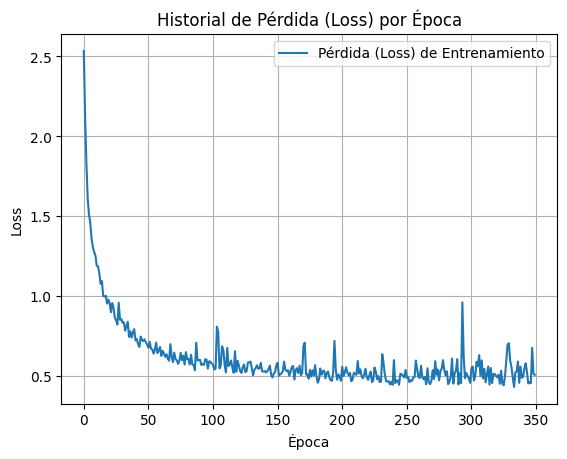


--- FASE 5: Probando modelo en cuda ---
Evaluando modelo contra el conjunto de prueba...


Evaluando: 100%|██████████| 230/230 [00:39<00:00,  5.79batch/s]



          RESULTADOS DE LA EVALUACIÓN (BIOMAS)
Accuracy (Exactitud): 0.7268 (72.68%)
Precision (Precisión - Macro): 0.7012 (70.12%)
Recall (Sensibilidad - Macro): 0.6991 (69.91%)

--- Reporte de Clasificación (Precisión, Recall, F1) ---
                        precision    recall  f1-score   support

              Badlands       0.98      0.97      0.98        64
          Bosque Mixto       0.29      0.25      0.27       459
       Bosque de Abeto       0.73      0.51      0.60       355
       Bosque de Roble       0.59      0.72      0.65       930
Bosque de Roble Oscuro       0.50      0.61      0.55       302
              Desierto       0.97      0.91      0.94       682
                Jungla       0.45      0.91      0.60       139
        Montaña Nevada       0.35      0.60      0.44       173
              Montañas       0.87      0.67      0.76       869
               Pantano       0.79      0.41      0.54       215
             Planicies       0.85      0.88      0.86    

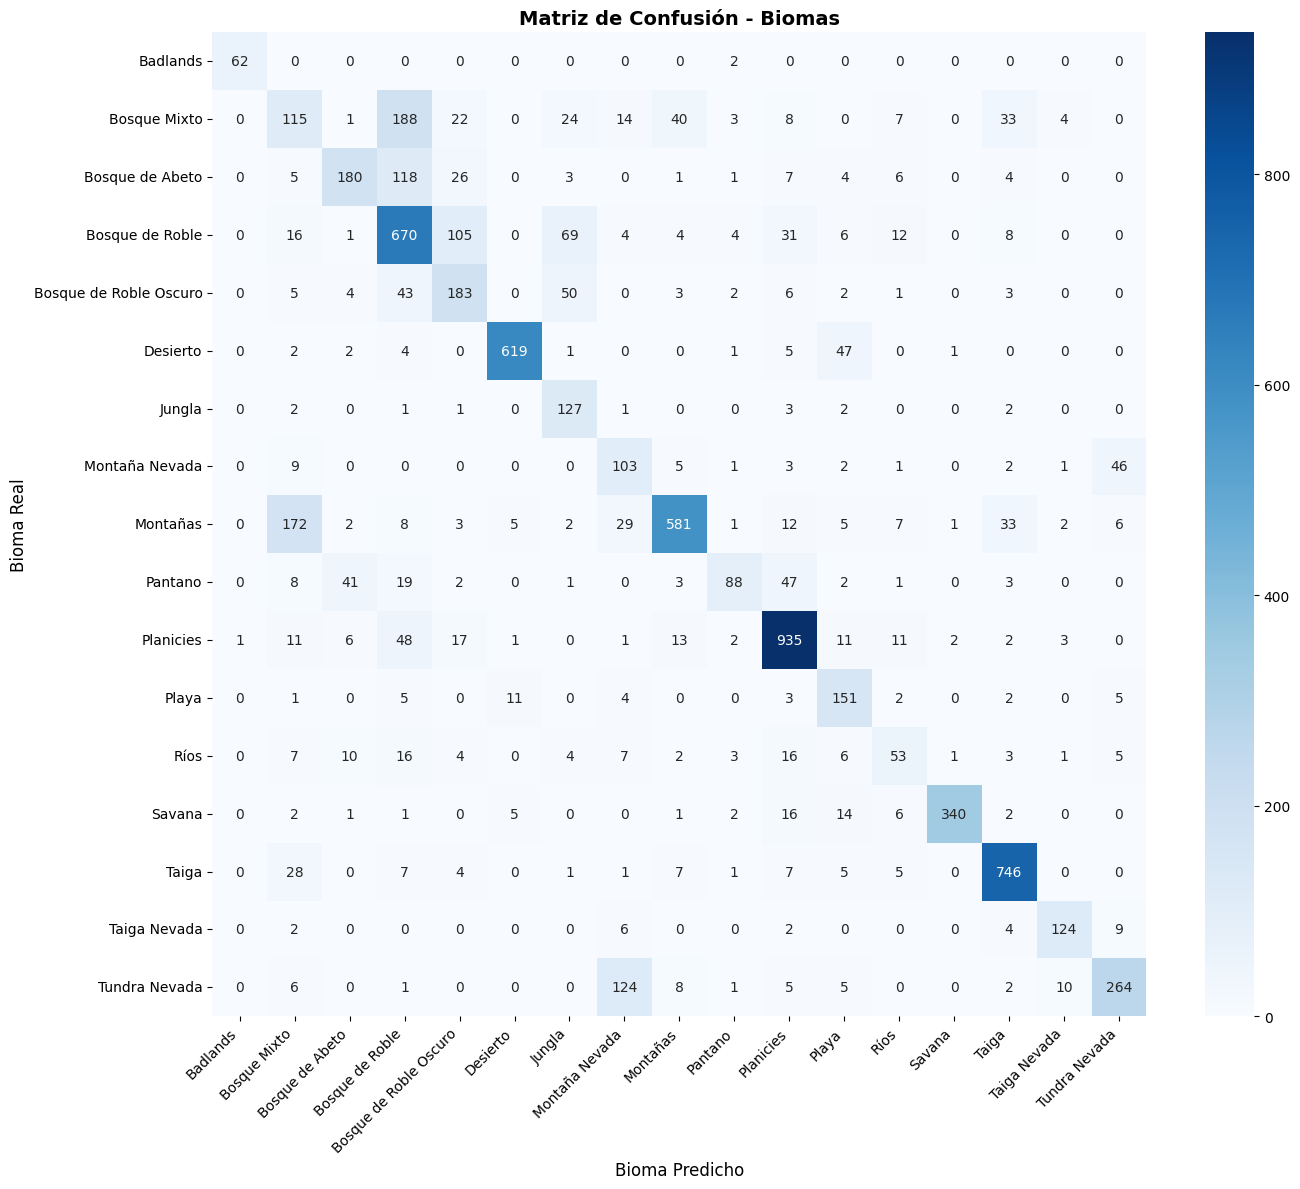

Gráfico de Matriz de Confusión generado.

--- FASE 6: Guardando modelo ---
Modelo guardado en /kaggle/working/auto_model_estandar_20251109_110612.pth

--- FLUJO AUTOMÁTICO COMPLETADO ---


In [9]:
if __name__ == "__main__":
    np.random.seed(SEMILLA_ALEATORIA)
    torch.manual_seed(SEMILLA_ALEATORIA)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEMILLA_ALEATORIA)

    tipo_ejecucion_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown')

    if tipo_ejecucion_kaggle == 'Interactive':
        print("--- MODO INTERACTIVO (DRAFT) ---")
        print("Iniciando menú principal. Podrá usar 'input()'.\n")
        menu_principal()
    
    else:
        if tipo_ejecucion_kaggle == 'Batch':
            print("--- MODO NO INTERACTIVO (COMMIT / RUN ALL) ---")
        else:
            print(f"--- MODO NO INTERACTIVO (Fallback, KAGGLE_KERNEL_RUN_TYPE={tipo_ejecucion_kaggle}) ---")
        
        print("Iniciando flujo automático (sin inputs).\n")
        
        modelo_automatico = None
        params_arquitectura_auto = None
        historial_perdida_auto = []
        dispositivo_auto = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f" (Usando dispositivo: {dispositivo_auto})")

        try:
            print("\n--- FASE 1: Agrupando y verificando el dataset ---")
            if not preparar_y_agrupar_biomas():
                print("Error crítico en la agrupación del dataset. Abortando.")
                sys.exit(1)

            print("\n--- FASE 2: Cargando y preparando datasets (PyTorch) ---")
            datos_entrenamiento, pesos_muestras_tensor, cargador_validacion, nombres_clases, numero_de_clases = cargar_y_preparar_datos(DIRECTORIO_DATOS)
            if datos_entrenamiento is None:
                print("No se pudieron cargar los datos. Abortando.")
                sys.exit(1)

            print("\n--- FASE 3: Creación de Modelo (CNN) ---")
            tipo_arquitectura_auto = "estandar"
            print(f"Arquitectura seleccionada: {tipo_arquitectura_auto}")
            
            params_arquitectura_auto = {
                'num_classes': numero_de_clases,
                'architecture_type': tipo_arquitectura_auto
            }
            params_creacion_auto = {
                'numero_de_clases': params_arquitectura_auto['num_classes'],
                'tipo_arquitectura': params_arquitectura_auto['architecture_type']
            }
            
            modelo_automatico = ClasificadorBiomasCNN(**params_creacion_auto).to(dispositivo_auto)
            print("\n--- Nueva Red CNN Creada ---")

            epocas_auto = 1000
            lr_auto = 0.005
            porcentaje_auto = 1.0
            print(f"\n--- FASE 4: Iniciando Entrenamiento ---")
            print(f"Épocas: {epocas_auto}, LR: {lr_auto}, Dataset: {porcentaje_auto*100:.0f}%")
            
            total_muestras = len(pesos_muestras_tensor)
            muestras_a_usar = int(total_muestras * porcentaje_auto)
            muestreador_auto = torch.utils.data.WeightedRandomSampler(
                weights=pesos_muestras_tensor,
                num_samples=muestras_a_usar,
                replacement=True
            )
            cargador_entrenamiento_auto = DataLoader(datos_entrenamiento,
                                                    batch_size=TAMANO_LOTE,
                                                    sampler=muestreador_auto,
                                                    num_workers=2,
                                                    pin_memory=True)
            
            nueva_perdida_auto = entrenar_modelo(modelo_automatico, cargador_entrenamiento_auto, epocas_auto, lr_auto, dispositivo_auto)
            historial_perdida_auto.extend(nueva_perdida_auto)
            
            print("Generando gráfico de pérdida...")
            graficar_historial_perdida(historial_perdida_auto)

            print(f"\n--- FASE 5: Probando modelo en {dispositivo_auto} ---")
            evaluar_modelo(modelo_automatico, cargador_validacion, dispositivo_auto, nombres_clases)

            print("\n--- FASE 6: Guardando modelo ---")
            marca_temporal = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            nombre_archivo_modelo = f"auto_model_estandar_{marca_temporal}.pth"
            guardar_red_neuronal(modelo_automatico, params_arquitectura_auto, nombre_archivo_modelo)
            
            print("\n--- FLUJO AUTOMÁTICO COMPLETADO ---")

        except Exception as e:
            print(f"Ocurrió un error en el flujo automático: {e}")
            import traceback
            traceback.print_exc()
            sys.exit(1)